# Homework 2

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.

## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM

## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew,kurtosis,norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import interpolate

import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

file = "../../data/treasury_ts_2015-08-15.xlsx"

database = pd.read_excel(file, sheet_name= "database")
bonds = [204046, 204047]

database_filter = database[database["kytreasno"].isin(bonds)].copy()
database_filter.columns = database_filter.columns.str.upper()
info = pd.read_excel(file,sheet_name='info',index_col=0)


In [58]:
def get_key_info(info):
    keys = ['kytreasno','tdatdt','tmatdt','tcouprt','itype']
    key_info = info.loc[keys]
    key_info.index = ['kytreasno','issue date','maturity date','coupon rate','type']
    key_info.loc['type',key_info.loc['type']==1] = 'bond'
    key_info.loc['type',key_info.loc['type']==2] = 'note'
    key_info.loc['type',key_info.loc['type']==3] = 'bill'
    key_info.loc['type',key_info.loc['type']==11] = 'TIPS bond'
    key_info.loc['type',key_info.loc['type']==12] = 'TIPS note'
    key_info.columns = key_info.loc['issue date']
    return key_info

def get_snapshot(database,date):    
    
    datasnap = database[database['CALDT']==date].T
    
    metrics = datasnap.loc[['KYTREASNO','CALDT','TDBID','TDASK','TDACCINT']]
    metrics.loc['clean price'] = (metrics.loc['TDBID'] + metrics.loc['TDASK'])/2
    metrics.loc['dirty price'] = metrics.loc['clean price'] + metrics.loc['TDACCINT']
    metrics.loc['duration'] = datasnap.loc['TDDURATN'] / 365.25
    ytm = (datasnap.loc['TDYLD'] * 365.25)
    metrics.loc['modified duration'] = metrics.loc['duration'] / (1+ytm/2)
    metrics.loc['ytm'] = ytm
    metrics.columns = metrics.loc['CALDT']
    metrics.drop('CALDT',inplace=True)
    metrics.index = metrics.index.str.lower()
    metrics.rename({'tdbid':'bid','tdask':'ask','tdaccint':'accrued interest'},inplace=True)
    
    return metrics
def get_table(info,database,date):

    keyinfo = get_key_info(info)
    metrics = get_snapshot(database,date)

    table = pd.merge(keyinfo.T,metrics.T,on='kytreasno',how='inner').T
    table.columns = table.loc['kytreasno']
    table.drop('kytreasno',inplace=True)
    
    return table

def calculate_hedge_position(agg_info, key_long, key_short, long_position=1000000, leverage=50, spread=0.01/100):


    # Calculate leverage and hedge ratio
    leverage_long = long_position * leverage
    # hedge_ratio = -agg_info.loc["duration", key_long] / agg_info.loc["duration", key_short]
    hedge_ratio = -(agg_info.loc["duration", key_long]*agg_info.loc["dirty price", key_long]) / (agg_info.loc["duration", key_short]*agg_info.loc["dirty price", key_short])


    # Initialize Hedge Position DataFrame
    hedge_position = pd.DataFrame(index=[key_long, key_short], columns=["Equity", "Assets", "Contracts"])
    hedge_position.loc[key_long, "Equity"] = long_position
    hedge_position.loc[key_short, "Equity"] = long_position * hedge_ratio
    hedge_position.loc[key_long, "Assets"] = leverage_long
    hedge_position.loc[key_short, "Assets"] = leverage_long * hedge_ratio
    hedge_position.loc[key_long, "Contracts"] = hedge_position.loc[key_long, "Assets"] / agg_info.loc["dirty price", key_long]
    hedge_position.loc[key_short, "Contracts"] = hedge_position.loc[key_short, "Assets"] / agg_info.loc["dirty price", key_short]

    # Create Hedge Position PnL DataFrame
    hedge_position_pnl = hedge_position.copy()
    hedge_position_pnl["Mod Duration"] = [
        agg_info.loc["modified duration", key_long],
        agg_info.loc["modified duration", key_short]
    ]
    hedge_position_pnl["YTM Change"] = spread / 2 * np.array([-1, 1])
    hedge_position_pnl["Dirty Price"] = [
        agg_info.loc["dirty price", key_long],
        agg_info.loc["dirty price", key_short]
    ]
    hedge_position_pnl["Change in Dirty Price"] = -hedge_position_pnl["Dirty Price"] * \
                                                   hedge_position_pnl["Mod Duration"] * \
                                                   hedge_position_pnl["YTM Change"]
    hedge_position_pnl["PnL"] = hedge_position_pnl["Change in Dirty Price"] * hedge_position_pnl["Contracts"]
    hedge_position_pnl.loc['total', 'PnL'] = hedge_position_pnl['PnL'].sum()
    hedge_position_pnl["Return"] = hedge_position_pnl["PnL"] / hedge_position_pnl["Equity"].abs().sum()

    return hedge_position_pnl


def get_coupon_dates(quote_date, maturity_date, valid_dates_list=None):

    if isinstance(quote_date, str):
        quote_date = datetime.datetime.strptime(quote_date, '%Y-%m-%d')
    if isinstance(maturity_date, str):
        maturity_date = datetime.datetime.strptime(maturity_date, '%Y-%m-%d')
    

    periods = int(np.ceil((maturity_date - quote_date).days / 180.0))
    temp = pd.date_range(end=maturity_date, periods=periods, freq=pd.DateOffset(months=6))
    

    out = pd.Series(temp[temp > quote_date])
    
    if valid_dates_list is None or len(valid_dates_list) == 0:
        return out
    

    valid_dates = []
    for d in valid_dates_list:
        if isinstance(d, str):
            d = datetime.datetime.strptime(d, '%Y-%m-%d')
        valid_dates.append(d)
    valid_dates = sorted(valid_dates)  

    corrected_dates = []
    for date_in_out in out:
        if date_in_out in valid_dates:
            # If the date is already in the valid list, keep it
            corrected_dates.append(date_in_out)
        else:
            # Find the next valid date strictly greater than our coupon date
            possible_replacements = [v for v in valid_dates if v > date_in_out]
            if possible_replacements:
                corrected_dates.append(min(possible_replacements))
            else:
              
                corrected_dates.append(date_in_out)

    return pd.Series(corrected_dates)

In [59]:
t0 = "2008-11-04"

agg_info = get_table(info,database_filter,t0)
display(agg_info)

c:\Users\josel\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)
c:\Users\josel\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


kytreasno,204046,204047
issue date,1985-08-15 00:00:00,2005-08-15 00:00:00
maturity date,2015-08-15 00:00:00,2015-08-15 00:00:00
coupon rate,10.625,4.25
type,bond,note
bid,141.859375,105.953125
ask,141.890625,105.984375
accrued interest,2.338655,0.935462
clean price,141.875,105.96875
dirty price,144.213655,106.904212
duration,5.230138,5.935706


In [60]:
keyLong = agg_info.loc['ytm'].idxmax()
keyShort = agg_info.loc['ytm'].idxmin()
Long_positon = 1000000
Leverage = 50
Leverage_Long = Long_positon * Leverage

hedge_position_pnl = calculate_hedge_position(agg_info, keyLong, keyShort, Long_positon, Leverage, spread=0.01/100)

hedge_position_pnl[["Equity", "Assets", "Contracts"]].style.format("{:,.0f}")

,Equity,Assets,Contracts
204046,"1,000,000","50,000,000","346,708"
204047,"-1,188,645","-59,432,273","-555,939"
total,nan,nan,nan


## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 

In [61]:
display(hedge_position_pnl[["PnL","Return"]].style.format({'Return':'{:.2%}','PnL':'${:,.2f}'}))
print(f"For every bps change in yield, the portfolio will make {hedge_position_pnl.loc['total','PnL']:.2f} USD")

,PnL,Return
204046,"$12,845.71",0.59%
204047,"$17,357.76",0.79%
total,"$30,203.47",1.38%


For every bps change in yield, the portfolio will make 30203.47 USD


In [62]:
hedge_position_pnl = calculate_hedge_position(agg_info, keyLong, keyShort, Long_positon, Leverage, spread=0.17*2/100)

display(hedge_position_pnl[["PnL","Return"]].style.format({'Return':'{:.2%}','PnL':'${:,.2f}'}))
print(f"For every bps change in yield, the portfolio will make {hedge_position_pnl.loc['total','PnL']:.2f} USD")

,PnL,Return
204046,"$436,754.16",19.96%
204047,"$590,163.69",26.96%
total,"$1,026,917.85",46.92%


For every bps change in yield, the portfolio will make 1026917.85 USD


<Axes: title={'center': 'Yield Spread'}, xlabel='CALDT', ylabel='bps'>

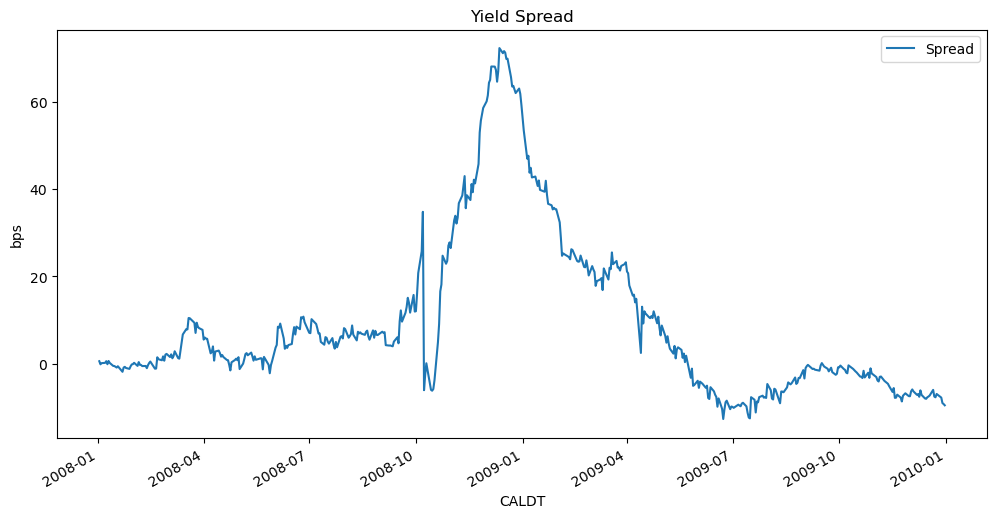

In [63]:
database_filter["YTM"] = database_filter["TDYLD"] * 365.25

YTM = pd.pivot_table(database_filter,index="CALDT",columns="KYTREASNO",values="YTM")
YTM["Spread"] = (YTM[keyLong] - YTM[keyShort])*100*100 # Basis points

YTM[(YTM.index <= "2009-12-31")&(YTM.index >= "2008-01-01")].plot(ylabel='bps',y="Spread",title="Yield Spread",figsize=(12,6))

## 1.4 Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?


In [64]:
database_filter["dirty price"] = (database_filter["TDBID"] + database_filter["TDASK"])/2 + database_filter["TDACCINT"]
database_filter["duration"] = database_filter["TDDURATN"] / 365.25


PnL_hist = pd.pivot_table(database_filter,index="CALDT",columns="KYTREASNO",values="dirty price")
PnL_hist.index = pd.to_datetime(PnL_hist.index)
PnL_hist = PnL_hist[PnL_hist.index >= t0]
PnL_hist = PnL_hist.diff().cumsum()
PnL_hist["Price Change"] = PnL_hist[keyLong]*hedge_position_pnl.loc[keyLong, "Contracts"] + PnL_hist[keyShort]*hedge_position_pnl.loc[keyShort, "Contracts"]

cpn_dates = get_coupon_dates(t0, agg_info.loc["maturity date", keyLong],PnL_hist.index.values)
PnL_hist["Coupons"] = 0 
PnL_hist.loc[PnL_hist.index.isin(cpn_dates.values), "Coupons"] = ((agg_info.loc["coupon rate"]/2 * hedge_position_pnl[ "Contracts"])).sum()
PnL_hist["Coupons"] = PnL_hist["Coupons"].cumsum()

PnL_hist["Total PnL"] = PnL_hist["Price Change"] + PnL_hist["Coupons"]

C:\Users\josel\AppData\Local\Temp\ipykernel_16312\233435846.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '660513.8164193293' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  PnL_hist.loc[PnL_hist.index.isin(cpn_dates.values), "Coupons"] = ((agg_info.loc["coupon rate"]/2 * hedge_position_pnl[ "Contracts"])).sum()


In [65]:
PnL_hist = pd.merge(PnL_hist[["Price Change","Coupons","Total PnL"]],YTM[['Spread']],left_index=True,right_index=True)

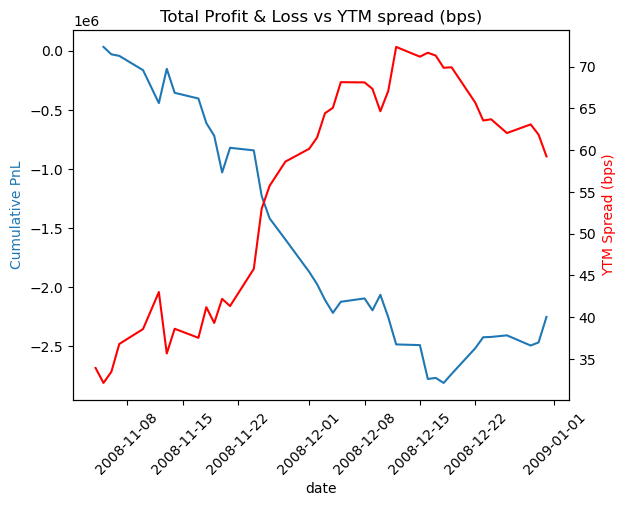

In [66]:
PnL_hist_filt = PnL_hist[PnL_hist.index <= "2008-12-31"]    

fig, ax = plt.subplots()

ax.plot(PnL_hist_filt[['Total PnL']])
ax.set_xlabel('date');
ax.set_ylabel('Cumulative PnL',color=ax.get_lines()[-1].get_color());
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()
ax2.plot(PnL_hist_filt[['Spread']], color='r')
ax2.set_ylabel('YTM Spread (bps)',color=ax2.get_lines()[-1].get_color());

ax.set_title('Total Profit & Loss vs YTM spread (bps)');

In [67]:
PnL_hist_filt[PnL_hist_filt.index.isin(["2008-11-25","2008-12-16"])].style.format("{:,.2f}")

C:\Users\josel\AppData\Local\Temp\ipykernel_16312\3580929752.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  PnL_hist_filt[PnL_hist_filt.index.isin(["2008-11-25","2008-12-16"])].style.format("{:,.2f}")


KYTREASNO,Price Change,Coupons,Total PnL,Spread
CALDT,,,,
2008-11-25 00:00:00,"-1,230,615.93",0.00,"-1,230,615.93",52.99
2008-12-16 00:00:00,"-2,779,846.99",0.00,"-2,779,846.99",71.66


In [68]:
hedge_position_pnl = calculate_hedge_position(agg_info, keyLong, keyShort, Long_positon, Leverage, spread=-(0.53-0.3390)/100)
print("Spread from 0.34 to 0.53")
display(hedge_position_pnl[["PnL","Return"]].style.format({'Return':'{:.2%}','PnL':'${:,.2f}'}))
print("Spread from 0.34 to 0.72")
hedge_position_pnl = calculate_hedge_position(agg_info, keyLong, keyShort, Long_positon, Leverage, spread=-(0.72-0.3390)/100)
display(hedge_position_pnl[["PnL","Return"]].style.format({'Return':'{:.2%}','PnL':'${:,.2f}'}))


Spread from 0.34 to 0.53


,PnL,Return
204046,"$-245,353.07",-11.21%
204047,"$-331,533.13",-15.15%
total,"$-576,886.21",-26.36%


Spread from 0.34 to 0.72


,PnL,Return
204046,"$-489,421.57",-22.36%
204047,"$-661,330.49",-30.22%
total,"$-1,150,752.06",-52.58%


It's a good aproximation, but with a higher difference the first derivate (Duration) is not enough to explain the real PnL/change in price


## 1.5 Examining the Trade through June 2009

Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

In [69]:
dates = ["2009-01-27","2009-03-24","2009-06-16"]
PnL_hist[PnL_hist.index.isin(dates)].style.format("{:,.2f}")

C:\Users\josel\AppData\Local\Temp\ipykernel_16312\1010510650.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  PnL_hist[PnL_hist.index.isin(dates)].style.format("{:,.2f}")


KYTREASNO,Price Change,Coupons,Total PnL,Spread
CALDT,,,,
2009-01-27 00:00:00,"-1,305,441.63",0.00,"-1,305,441.63",35.36
2009-03-24 00:00:00,"-1,553,265.82","660,513.82","-892,752.00",22.03
2009-06-16 00:00:00,"63,263.67","660,513.82","723,777.49",-7.14


In [70]:
hedge_position_pnl = calculate_hedge_position(agg_info, keyLong, keyShort, Long_positon, Leverage, spread=-(0.3536-0.3390)/100)
print("Spread from 0.34 to 0.3536")
display(hedge_position_pnl[["PnL","Return"]].style.format({'Return':'{:.2%}','PnL':'${:,.2f}'}))
print("Spread from 0.34 to 0.2203")
hedge_position_pnl = calculate_hedge_position(agg_info, keyLong, keyShort, Long_positon, Leverage, spread=-(0.2203-0.3390)/100)
display(hedge_position_pnl[["PnL","Return"]].style.format({'Return':'{:.2%}','PnL':'${:,.2f}'}))
print("Spread from 0.34 to -0.0714")
hedge_position_pnl = calculate_hedge_position(agg_info, keyLong, keyShort, Long_positon, Leverage, spread=-(-0.0714-0.3390)/100)
display(hedge_position_pnl[["PnL","Return"]].style.format({'Return':'{:.2%}','PnL':'${:,.2f}'}))


Spread from 0.34 to 0.3536


,PnL,Return
204046,"$-18,754.74",-0.86%
204047,"$-25,342.32",-1.16%
total,"$-44,097.06",-2.01%


Spread from 0.34 to 0.2203


,PnL,Return
204046,"$152,478.58",6.97%
204047,"$206,036.56",9.41%
total,"$358,515.14",16.38%


Spread from 0.34 to -0.0714


,PnL,Return
204046,"$527,187.96",24.09%
204047,"$712,362.29",32.55%
total,"$1,239,550.25",56.64%


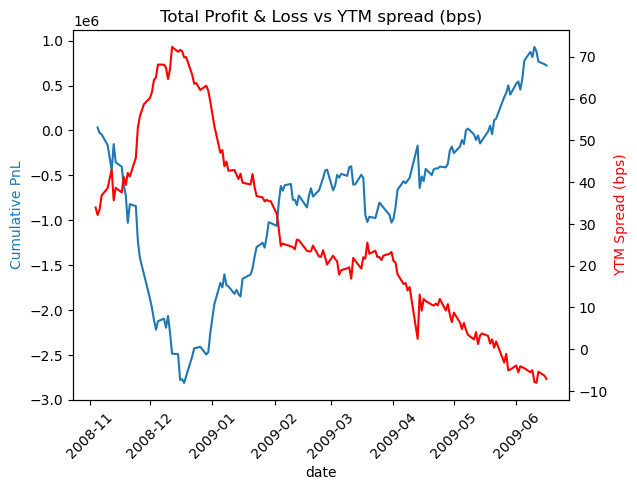

In [71]:
PnL_hist_filt = PnL_hist[PnL_hist.index <= "2009-06-16"]    

fig, ax = plt.subplots()

ax.plot(PnL_hist_filt[['Total PnL']])
ax.set_xlabel('date');
ax.set_ylabel('Cumulative PnL',color=ax.get_lines()[-1].get_color());
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()
ax2.plot(PnL_hist_filt[['Spread']], color='r')
ax2.set_ylabel('YTM Spread (bps)',color=ax2.get_lines()[-1].get_color());

ax.set_title('Total Profit & Loss vs YTM spread (bps)');

During the first six months, the spread converged to zero, resulting in a positive PnL. The estimation of PnL using Duration x Spread Movement is fairly accurate; however, there remains a discrepancy of 200k compared to the actual price on the last date. To enhance the approach, we could consider including convexity in the calculation.

***

# 2 Hedging Duration

Use data from `../data/treasury_ts_duration_2024-10-31.xlsx`.

The file contains time-series information on two treasuries. Observe the info of the securities with the following code:


In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew,kurtosis,norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import interpolate

In [73]:
QUOTE_DATE = '2024-10-31'
filepath = f'../../data/treasury_ts_duration_{QUOTE_DATE}.xlsx'

data = pd.read_excel(filepath,sheet_name='database')
data_info =  data.drop_duplicates(subset='KYTREASNO', keep='first').set_index('KYTREASNO')
data_info[['type','issue date','maturity date','cpn rate']]

,type,issue date,maturity date,cpn rate
KYTREASNO,,,,
207391,note,2019-08-15,2029-08-15,1.625
207392,bond,2019-08-15,2049-08-15,2.250


You will largely focus on the sheets which give the timeseries of prices and durations for each of the two securities, as shown in the following code.

In [74]:
SHEET_PRICE = 'price'
SHEET_DURATION = 'duration'
INDEX_NAME = 'quote date'

price = pd.read_excel(filepath,sheet_name=SHEET_PRICE).set_index(INDEX_NAME)
duration = pd.read_excel(filepath,sheet_name=SHEET_DURATION).set_index(INDEX_NAME)

display(price)
display(duration)

,207391,207392
quote date,,
2019-08-09,98.882812,99.789062
2019-08-12,99.796875,102.554688
2019-08-13,99.281250,101.867188
2019-08-14,100.406250,105.179688
2019-08-15,100.882812,106.234375
...,...,...
2024-11-22,88.740234,63.722656
2024-11-25,89.287109,65.378906
2024-11-26,89.214844,65.175781


,207391,207392
quote date,,
2019-08-09,9.289497,22.000102
2019-08-12,9.285468,22.118496
2019-08-13,9.280314,22.084308
2019-08-14,9.282750,22.228549
2019-08-15,9.282163,22.270910
...,...,...
2024-11-22,4.539445,17.205511
2024-11-25,4.531983,17.312267
2024-11-26,4.529132,17.295472


### 2.1.

Suppose you have a portfolio of `10,000` USD long in security `207391` on the first day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

In [75]:
key_long = 207391
key_short = 207392

Long_positon = 10000
hedge_ratio =  -((duration[key_long][0] * price[key_long][0])/ (duration[key_short][0]*price[key_short][0]))


# Initialize Hedge Position DataFrame
hedge_position = pd.DataFrame(index=[key_long, key_short], columns=["Assets", "Contracts"])
hedge_position.loc[key_long, "Assets"] = Long_positon
hedge_position.loc[key_short, "Assets"] = Long_positon * hedge_ratio
hedge_position.loc[key_long, "Contracts"] = hedge_position.loc[key_long, "Assets"] / price[key_long][0]
hedge_position.loc[key_short, "Contracts"] = hedge_position.loc[key_short, "Assets"] / price[key_short][0]

print("--------------------------")
print(f"Hedge Ratio: {hedge_ratio:.2f}")
display(hedge_position.style.format("{:,.1f}"))

--------------------------
Hedge Ratio: -0.42


C:\Users\josel\AppData\Local\Temp\ipykernel_16312\1770358164.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio =  -((duration[key_long][0] * price[key_long][0])/ (duration[key_short][0]*price[key_short][0]))
C:\Users\josel\AppData\Local\Temp\ipykernel_16312\1770358164.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_position.loc[key_long, "Contracts"] = hedge_position.loc[key_long, "Assets"] / price[key_long][0]
C:\Users\josel\AppData\Local\Temp\ipykernel_16312\1770358164.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will a

,Assets,Contracts
207391,"10,000.0",101.1
207392,"-4,184.1",-41.9



### 2.2.

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be `10,000`.
* Repeat throughout the timeseries.

Calculate the daily profit and loss (PnL) for the
* dynamically hedged position constructed above.
* long-only position, (still at `10,000` throughout.)

(You might check to verify that the net duration is zero at all dates.)

Report...
* the cumulative PnL of both strategies via a plot.
* the (daily) mean, standard deviation, min, and max of the PnL in a table.


In [76]:
tracking_pnl = pd.DataFrame(index=price.index)

tracking_pnl["Long_position"] = Long_positon / price[key_long]
tracking_pnl["Hedge_Ratio"] = -(duration[key_long] * price[key_long]) / (duration[key_short] * price[key_short])
tracking_pnl["Short_position"] = tracking_pnl["Long_position"] * tracking_pnl["Hedge_Ratio"]
tracking_pnl["Long_asset"] = Long_positon
tracking_pnl["Short_asset"] = tracking_pnl["Short_position"] * price[key_short]
tracking_pnl[["Realized_Long", "Realized_Short"]] =(tracking_pnl[["Long_position","Short_position"]].shift() * price[[key_long,key_short]].values)

tracking_pnl["PnL"] = (tracking_pnl["Realized_Long"] + tracking_pnl["Realized_Short"]) - (tracking_pnl["Long_asset"].shift() + tracking_pnl["Short_asset"].shift())

wts = tracking_pnl[['Long_asset','Short_asset']].div(tracking_pnl[['Long_asset','Short_asset']].sum(axis=1),axis=0)
tracking_pnl["Duration"] = (wts * duration[[key_long,key_short]].values).sum(axis=1)

In [77]:
display(tracking_pnl)
display(tracking_pnl[['PnL','Duration']].describe().T.style.format('{:.1f}'))

,Long_position,Hedge_Ratio,Short_position,Long_asset,Short_asset,Realized_Long,Realized_Short,PnL,Duration
quote date,,,,,,,,,
2019-08-09,101.129810,-0.418413,-42.314047,10000,-4222.479083,NaN,NaN,NaN,3.552714e-15
2019-08-12,100.203538,-0.408517,-40.934802,10000,-4198.055835,10092.438967,-4339.503869,-24.585820,-3.552714e-15
2019-08-13,100.723953,-0.409555,-41.251958,10000,-4202.220951,9948.332550,-4169.913158,-23.524773,-3.552714e-15
2019-08-14,99.595394,-0.398652,-39.703946,10000,-4176.048586,10113.314448,-4338.868062,-23.332664,0.000000e+00
2019-08-15,99.124913,-0.395789,-39.232518,10000,-4167.842047,10047.463430,-4217.923841,5.588175,5.329071e-15
...,...,...,...,...,...,...,...,...,...
2024-11-22,112.688456,-0.367419,-41.403909,10000,-2638.367073,9998.679607,-2643.726892,-4.642675,8.881784e-16
2024-11-25,111.998250,-0.357508,-40.040242,10000,-2617.787204,10061.626499,-2706.942298,-6.948725,-8.881784e-16
2024-11-26,112.088971,-0.358454,-40.178741,10000,-2618.680845,9991.906379,-2609.654032,0.039551,8.881784e-16


,count,mean,std,min,25%,50%,75%,max
PnL,1329.0,0.1,21.1,-98.3,-11.0,0.0,10.4,118.4
Duration,1330.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0


<Axes: title={'center': 'PnL without coupons'}, xlabel='quote date'>

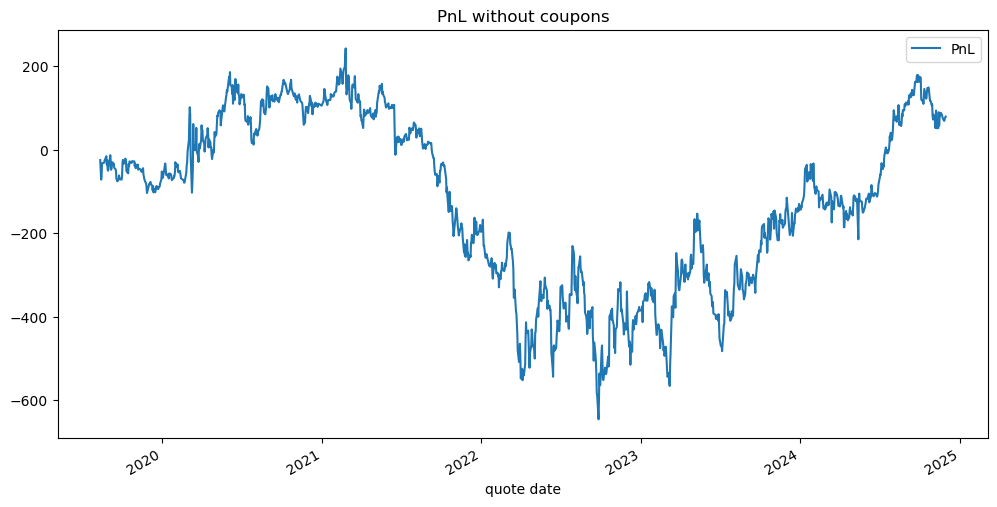

In [78]:
tracking_pnl[["PnL"]].cumsum().plot(title="PnL without coupons",figsize=(12,6))

### 2.3.

Give two reasons that the daily PnL is not always zero for the hedged position given that we have perfectly hedged the duration.

- Because we are not taking into account the convexity difference between the bonds on the hedge ratio
- And duration only take into account parallel shifts, but usually the movement on the spot/yield curve are not parallel (slope change)

### 2.4.
The PnL above doesn't account for the coupons.

Calculate a dataframe indexed by dates with columns for the two treasuries with values of coupon payments. 
* Recall that the stated coupon rate is semiannual, so at any give coupon date, it pays half the stated rate.
* Figure out the coupon dates by using the `data` tab and looking for dates where `acc int` goes down. Recall that accrued interest measures the portion of the coupon period that has passed. So when this resets, it is because the coupon has been paid.

Report the first 5 dates that a coupon is paid (by either bond).

In [79]:
data.sort_values(by=['KYTREASNO','quote date'],inplace=True)

In [80]:
accrued_int = pd.pivot_table(data,index='quote date',columns='KYTREASNO',values='accrued int')
coupons_dates = accrued_int[(accrued_int.diff()<0).any(axis=1)].index.values
print(coupons_dates)

['2020-02-18T00:00:00.000000000' '2020-08-17T00:00:00.000000000'
 '2021-02-16T00:00:00.000000000' '2021-08-16T00:00:00.000000000'
 '2022-02-15T00:00:00.000000000' '2022-08-15T00:00:00.000000000'
 '2023-02-15T00:00:00.000000000' '2023-08-15T00:00:00.000000000'
 '2024-02-15T00:00:00.000000000' '2024-08-15T00:00:00.000000000']


In [81]:
tracking_pnl["Coupon_Long"] = 0
tracking_pnl["Coupon_Short"] = 0

tracking_pnl.loc[coupons_dates,"Coupon_Long"] = data_info.loc[key_long,"cpn rate"]/2
tracking_pnl.loc[coupons_dates,"Coupon_Short"] = data_info.loc[key_short,"cpn rate"]/2

tracking_pnl["Coupon_PnL"] = (tracking_pnl["Coupon_Long"] * tracking_pnl["Long_position"].shift()) + (tracking_pnl["Coupon_Short"] * tracking_pnl["Short_position"].shift())

tracking_pnl["Total_PnL"] = tracking_pnl["PnL"] + tracking_pnl["Coupon_PnL"]

C:\Users\josel\AppData\Local\Temp\ipykernel_16312\1412232009.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tracking_pnl.loc[coupons_dates,"Coupon_Long"] = data_info.loc[key_long,"cpn rate"]/2
C:\Users\josel\AppData\Local\Temp\ipykernel_16312\1412232009.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tracking_pnl.loc[coupons_dates,"Coupon_Short"] = data_info.loc[key_short,"cpn rate"]/2


### 2.5.
Account for the coupons in the PnL calculations of `2.2`. Report the updated PnL in a plot and a table, similar to the reporting in `2.2`.

In [82]:
display(tracking_pnl[['PnL','Total_PnL']].describe().T.style.format('{:.1f}'))

,count,mean,std,min,25%,50%,75%,max
PnL,1329.0,0.1,21.1,-98.3,-11.0,0.0,10.4,118.4
Total_PnL,1329.0,0.4,21.4,-98.3,-11.0,0.0,10.9,118.4


<Axes: title={'center': 'PnL without coupons'}, xlabel='quote date'>

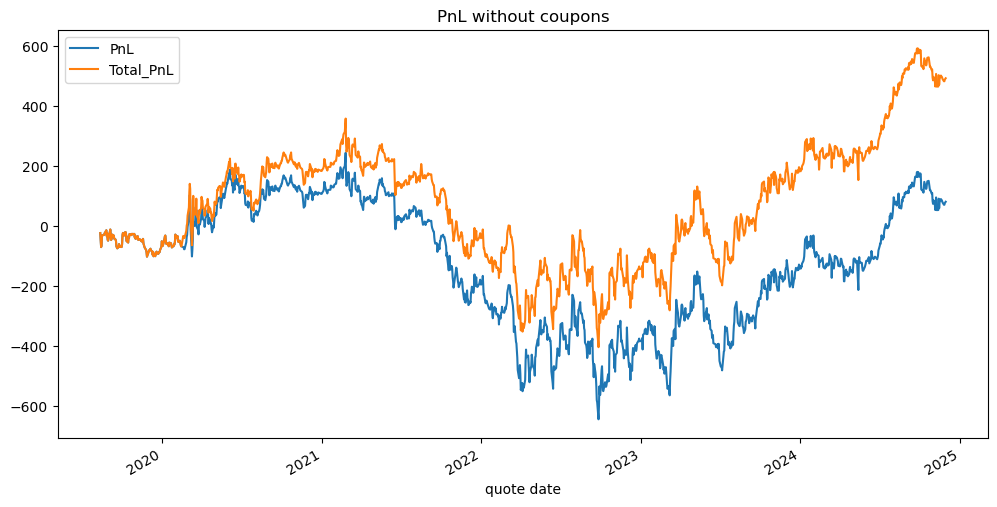

In [112]:
tracking_pnl[["PnL","Total_PnL"]].cumsum().plot(title="PnL without coupons",figsize=(12,6))

***